In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import numpy as np
import beadpy
import pandas as pd

In [ ]:
%matplotlib inline

In [356]:
def trajectory_simulator(pre_duration = 250, #Mean event start time
                         pre_sigma = 50, #Sigma of event start time distribution
                         post_duration = 250, #The bead stays on for this long at the end of the trajectory
                         mean_duration = 100, #Mean event duration
                         mean_rate = 500, #Mean rate (distance units/timestep)
                         rate_sigma = 50, #Sigma of the rate distribution
                         noise_sigma = 500, #Mean sigma for the bead movement
                         noise_sigma_sigma = 100, #Sigma of the noise sigma distribution
                         pause_prob = 0.001, #Probability of entering a pause in a given timestep
                         pause_duration_prob = 0.2, #Probability of remaining paused in a given timestep once a pause has begun.
                         rate_change_prob = 0.1, #Probablity that the rate will change in a given timestep
                         DNA_length = 15000, #Length of the DNA - a hard limit on the event length
                         trajectory_number = 0):
    length = int(np.random.exponential(mean_duration))
    current_rate = 0
    pre = int(np.random.normal(loc=pre_duration, scale = pre_sigma))
    post = post_duration
    rate = 0
    ratesequence = [0]*pre
    noise_sigmaval = int(np.random.normal(loc=noise_sigma, scale = noise_sigma_sigma))
    position = [0]*pre
    nucleotides = []
    current_position = 0
    for i in range(0,pre):
        nucleotides.append(float(position[i]+np.random.normal(loc=0.0, scale = noise_sigmaval)))
    for i in range(0,length):
        pause = random.random()
        if not rate == 0: #When during an event/no pause.
            if (pause <= pause_prob): #Start a pause
                rate = 0
            elif (pause > pause_prob) & (pause <= (pause_prob + rate_change_prob)): #Change the rate
                current_rate = np.random.normal(loc=mean_rate, scale = rate_sigma)
                rate = current_rate
            else: #No rate change
                rate = current_rate          
        elif rate == 0: #When in a pause
            if (pause < (1- pause_duration_prob)): #End the pause
                rate = np.random.normal(loc=mean_rate, scale = rate_sigma)
            else:
                rate = 0 #Continue the pause
        ratesequence.append(rate)
        current_position = current_position + rate
        position.append(current_position)
        nucleotides.append(float(current_position+np.random.normal(loc=0.0, scale = noise_sigmaval)))
        if current_position > DNA_length:
            length = i
            break
    for i in range(0,post):
        ratesequence.append(0)
        position.append(current_position)
        nucleotides.append(float(current_position+np.random.normal(loc=0.0, scale = noise_sigmaval)))
    time = range(0,len(nucleotides))
    results = pd.DataFrame({'time' : time,
                        'nucleotides' : nucleotides,
                           'rate' : ratesequence,
                           'position' : position})
    results['trajectory'] = trajectory_number
    return results

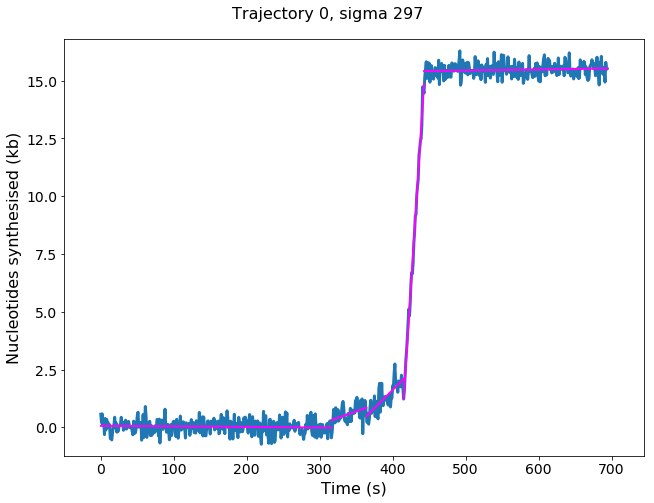

In [361]:
test = trajectory_simulator(pre_duration = 300, pre_sigma = 10, 
                                                   mean_duration = 120,
                                                   mean_rate = 450, rate_sigma = 150,
                                                   noise_sigma = 200, noise_sigma_sigma=50,
                                                   pause_prob = 0.001,pause_duration_prob = 0.95, trajectory_number = 0)
exampletrajseg = beadpy.trajectory_plotter(test, 0, method = ('auto', 'whole'), 
                                           sigma_start = 10, sigma_end = 250,  
                                           eventregion = (200,500), 
                                           segmenttable = 0)

In [239]:
exampletrajseg

,rate,intercept,x1,x2,y1,y2,displacement,duration,trajectory
0,0.1,-29.0,0.0,329.0,-28.9,2.1,31.0,329.0,0.0
1,40.6,-13185.0,329.0,395.0,163.9,2841.6,2677.8,66.0,0.0
2,3.1,1488.0,395.0,460.0,2719.8,2922.5,202.7,65.0,0.0
3,-4.9,5553.0,460.0,500.0,3282.6,3085.2,-197.4,40.0,0.0
4,247.5,-121195.0,500.0,509.0,2574.4,4802.2,2227.9,9.0,0.0
5,0.5,6909.0,509.0,762.0,7142.1,7258.1,116.0,253.0,0.0


Compare the table of actual changepoints below (ignoring rate changes of less than 10) with the above table of the discovered changepoints above.

In [240]:
changepoints = []
changepoint_values = []
for i in test.time[1:]:
    if abs(test.rate[i] - test.rate[i-1]) > 50:
        changepoints.append(i)
        changepoint_values.append(test.rate[i])
cpts = pd.DataFrame({'changepoint' : changepoints,
                    'rate' : changepoint_values})
cpts

,changepoint,rate
0,335,397.961153
1,336,0.000000
2,341,275.456259
3,342,0.000000
4,345,356.336878
5,346,0.000000
6,353,635.668670
7,354,0.000000
8,378,487.769109
9,379,0.000000


Generate a large results table.

In [354]:
results = pd.DataFrame()
for j in range(0,1000):
    temp = trajectory_simulator(pre_duration = 300, post_duration = 500,
                                pre_sigma = 10, 
                                mean_duration = 120,
                                DNA_length = 15000,
                                mean_rate = 450, rate_sigma = 150,
                                noise_sigma = 200, noise_sigma_sigma=50,
                                pause_prob = 0.001,pause_duration_prob = 0.95, 
                                trajectory_number = j)
    results = results.append(temp)
    

In [355]:
segments = beadpy.segment_finder(results, method = 'auto', sigma_start=10, sigma_end=250)

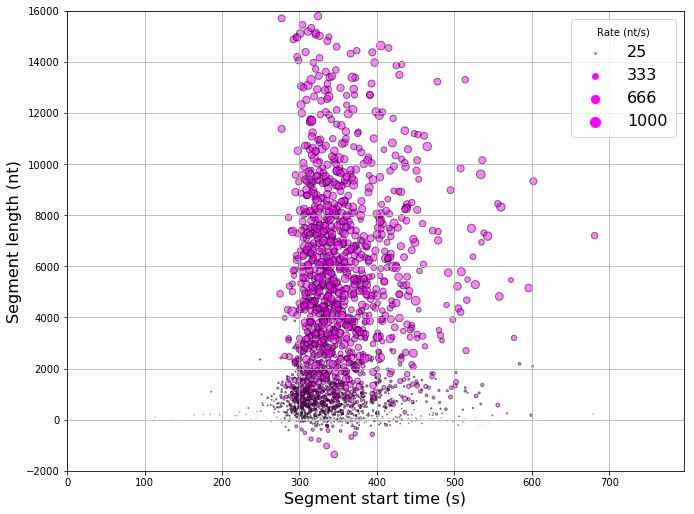

In [362]:
beadpy.segmentplotter(segments,1000,-2000,16000, 1, 10)